# Dimensionality reduction on mouse features coming from different splits

In [2]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import umap
from sklearn import mixture

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import trial_relative_frequency
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood

from one.api import ONE
one = ONE(mode='remote')

## Get data

In [3]:
# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE/')

# DATA used for COSYNE: states_trial_type_14oct2024

In [4]:
# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial01-09-2025')
old_trial_clusters = pd.read_parquet(filename, engine='pyarrow')

# # Load trial clsuters
# results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
# filename = str(results_path + 'cluster_per_trial_no_timing03-11-2025')
# trial_clusters = pd.read_parquet(filename, engine='pyarrow')

# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_no_timing03-19-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

# Load entropy file
# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'entropy03-13-2025')
ent = pd.read_parquet(filename, engine='pyarrow')

# Split sessions with random seed

In [5]:
random_state = 42
n_parts = 2

rng = np.random.default_rng(random_state)  # Random generator for reproducibility
# part_labels = []

trial_clusters['session_part'] = trial_clusters['response'] * np.nan

for s, session in enumerate(trial_clusters.session.unique()):
    session_df = trial_clusters.loc[trial_clusters['session']==session]
    n_trials = len(session_df)
    # Create shuffled labels for parts
    parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
    rng.shuffle(parts)  # Shuffle to randomize assignment
    # els.extend(parts)
    trial_clusters.loc[trial_clusters['session']==session, 'session_part'] = parts

# Assign to new column
trial_clusters['session_part'] = trial_clusters['session_part'].astype(str)
trial_clusters = trial_clusters.rename(columns={"sample": "old_sample"})
trial_clusters['sample'] = trial_clusters[['session', 'session_part']].agg(' '.join, axis=1)
# trial_clusters['sample'] = trial_clusters['old_sample'] + trial_clusters['session_part']

In [15]:
file_to_save = trial_clusters.copy()
filename = "cluster_per_trial_part_info"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = 'H_clustering_mice.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

# Cluster with consensus across repeats

In [7]:
def find_best_k(embedding, Ks):
    from kneed import KneeLocator
    # Assuming `X` is your data
    inertia_values = []
    
    for k in Ks:
        kmeans = KMeans(n_clusters=k)
        cutoff = int(np.shape(embedding)[0]*0.8)
        X_train = np.vstack([embedding[:cutoff, 0], embedding[:cutoff, 1]]).T
        kmeans.fit(X_train)
        inertia_values.append(kmeans.inertia_)
        
    kneedle = KneeLocator(Ks, inertia_values, curve="convex", direction="decreasing")
    optimal_k = kneedle.knee
    return optimal_k

def Ks_iter (ori_X, repeats, Ks):
    optimal_ks = np.zeros((repeats))
    
    # Embedd
    for r in range(repeats):
        reducer = umap.UMAP(n_components=2)
        embedding = reducer.fit_transform(ori_X)
        embedding.shape
        
        # Find ideal k
        optimal_k = find_best_k(embedding, Ks)
        optimal_ks[r] = optimal_k
        
    return optimal_ks


def cluster_consensus(ori_X, optimal_k, shuffle=False, repeats=100):
       
    # Initialize consensus matrix

    n_samples, _ = ori_X.shape
    consensus_matrix = np.zeros((n_samples, n_samples))
    
    # Embedd
    for r in range(repeats):
        reducer = umap.UMAP(n_components=2)

        if shuffle:
            shuffled_arr = np.apply_along_axis(np.random.permutation, 1, ori_X)
            part_embedding = reducer.fit_transform(shuffled_arr)
        else:
            part_embedding = reducer.fit_transform(ori_X)
        
        # Cluster
        kmeans = KMeans(n_clusters=optimal_k)
        kmeans.fit(part_embedding)
        labels = kmeans.predict(part_embedding)
        
        for i in range(n_samples):
            for j in range(i, n_samples):
                if labels[i] == labels[j]:
                    consensus_matrix[i, j] += 1
                    if i != j:
                        consensus_matrix[j, i] += 1  # symmetry
                            
    # Normalize to [0, 1]
    consensus_matrix /= repeats
    
    return consensus_matrix


def repeated_splits(trial_clusters, vars, n_parts, optimal_k, reps=10):

    sessions = trial_clusters.session.unique()
    session_num = len(sessions)
    all_cluster_repeats = pd.DataFrame(columns=['mouse_name', 'session', 'sample', 'y_kmeans', 'repeat'])
    # all_cluster_repeats = np.zeros((session_num * n_parts, reps)) * np.nan
    
    for r in range(reps):
        all_cluster = pd.DataFrame(columns=['mouse_name', 'session', 'sample', 'y_kmeans', 'repeat'], index=range(session_num * n_parts))
        use_df = trial_clusters.copy()
        use_df['session_part'] = use_df['response'] * np.nan

        for s, session in enumerate(sessions):
            session_df = use_df.loc[use_df['session']==session]
            n_trials = len(session_df)
            # Create shuffled labels for parts
            parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
            rng.shuffle(parts)  # Shuffle to randomize assignment
            use_df.loc[use_df['session']==session, 'session_part'] = parts

        # Assign to new column
        use_df['session_part'] = use_df['session_part'].astype(str)
        use_df = use_df.rename(columns={"sample": "old_sample"})
        use_df['sample'] = use_df[['session', 'session_part']].agg(' '.join, axis=1)
        
        # Prepare design matrix
        count, freq_df = trial_relative_frequency(use_df, vars)
        # keys = freq_df.reset_index()['sample']
        var_names = freq_df.keys()
        ori_X = np.array(freq_df[var_names])

        # Cluster and save
        consensus_matrix = cluster_consensus(ori_X, optimal_k, shuffle=False, repeats=10)
        # Perform final clustering on consensus matrix
        final_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage="average")
        mouse_y_kmeans = final_clustering.fit_predict(1 - consensus_matrix)  # Convert to similarity
        
        # Save
        info = use_df[['sample', 'mouse_name', 'session']].drop_duplicates().reset_index()
        all_cluster['mouse_name'] = info['mouse_name']
        all_cluster['session'] = info['session']
        all_cluster['sample'] = info['sample']
        all_cluster['y_kmeans'] = mouse_y_kmeans
        all_cluster['repeat'] = r
        all_cluster_repeats = pd.concat([all_cluster_repeats, all_cluster], ignore_index=True)

    
    return all_cluster_repeats


from scipy.stats import entropy

def agreement_ratio(all_cluster_repeats):
    cluster_entropy = pd.DataFrame(columns=['mouse_name', 'True', 'Shuffled', 'session_len'], index=range(len(all_cluster_repeats['mouse_name'].unique())))
    for m, mouse in enumerate(all_cluster_repeats['mouse_name'].unique()):
        cluster_entropy['mouse_name'][m] = mouse
        mouse_session_parts = all_cluster_repeats.loc[all_cluster_repeats['mouse_name']==mouse][['mouse_name', 'sample', 'y_kmeans', 'repeat']]
        mouse_repeats = mouse_session_parts['repeat'].unique()

        agree = []
        shuffle_agree = []
        for r, rep in enumerate(mouse_repeats):

            repeat_data = mouse_session_parts.loc[mouse_session_parts['repeat']==r, 'y_kmeans']
            # Count cluster label occurrences for sample i
            same = 1 if np.array(repeat_data)[0] == np.array(repeat_data)[1] else 0
            agree.append(same)

            # Test for random cluster assignment
            shuffle = np.random.randint(np.min(all_cluster_repeats['y_kmeans']), np.max(all_cluster_repeats['y_kmeans']), len(repeat_data))
            same_shuffle = 1 if shuffle[0]==shuffle[1] else 0
            shuffle_agree.append(same_shuffle)


        cluster_entropy['True'][m] = np.mean(agree)
        cluster_entropy['Shuffled'][m] = np.mean(shuffle_agree)
        cluster_entropy['session_len'][m] = np.floor(len(mouse_session_parts['sample'].unique())/2)

    melted_df = pd.melt(cluster_entropy, id_vars=['mouse_name', 'session_len'], value_vars=['True', 'Shuffled'])
    return melted_df

from scipy.stats import entropy
def calculate_entropy(all_cluster_repeats):
    
    cluster_entropy = pd.DataFrame(columns=['mouse_name', 'True', 'Shuffled', 'session_len'], index=range(len(all_cluster_repeats['mouse_name'].unique())))
    for m, mouse in enumerate(all_cluster_repeats['mouse_name'].unique()):
        cluster_entropy['mouse_name'][m] = mouse
        mouse_session_parts = all_cluster_repeats.loc[all_cluster_repeats['mouse_name']==mouse][['mouse_name', 'sample', 'y_kmeans', 'repeat']]
        mouse_repeats = mouse_session_parts['repeat'].unique()

        agree = []
        shuffle_agree = []
        
        for r, rep in enumerate(mouse_repeats):

            repeat_data = mouse_session_parts.loc[mouse_session_parts['repeat']==r, 'y_kmeans']
            # Count cluster label occurrences for sample i
            labels, counts = np.unique(np.array(repeat_data), return_counts=True)
            prob = counts / counts.sum()
            ent = entropy(prob)  # Shannon entropy
            # same = 1 if np.array(repeat_data)[0] == np.array(repeat_data)[1] else 0
            # agree.append(same)
            agree.append(ent)

            # Test for random cluster assignment
            shuffle = np.random.randint(np.min(all_cluster_repeats['y_kmeans']), np.max(all_cluster_repeats['y_kmeans']), len(repeat_data))
            # same_shuffle = 1 if shuffle[0]==shuffle[1] else 0
            # shuffle_agree.append(same_shuffle)
            _, shuffle_counts = np.unique(shuffle, return_counts=True)
            shuff_prob = shuffle_counts / shuffle_counts.sum()
            shuff_ent = entropy(shuff_prob)  # Shannon entropy
            shuffle_agree.append(shuff_ent)

        cluster_entropy['True'][m] = np.mean(agree)
        cluster_entropy['Shuffled'][m] = np.mean(shuffle_agree)
        cluster_entropy['session_len'][m] = np.floor(len(mouse_session_parts['sample'].unique())/2)

    melted_df = pd.melt(cluster_entropy, id_vars=['mouse_name', 'session_len'], value_vars=['True', 'Shuffled'])
    return melted_df


In [23]:
vars = ['mouse_name', 'cluster']
vars = ['sample', 'cluster']

# Filter mice with multiple sessions
filter_mice = ent.loc[ent['session_len']>1, 'mouse_name']
use_data = trial_clusters.loc[trial_clusters['mouse_name'].isin(filter_mice)]
use_data = trial_clusters.copy()
# Prepare design matrix
count, freq_df = trial_relative_frequency(use_data, vars)
var_names = freq_df.keys()
ori_X = np.array(freq_df[var_names])

# Find optimal Ks
Ks = range(1, 10)
repeats = 10
# optimal_ks = Ks_iter (ori_X, repeats, Ks)
optimal_k = 3

# Cluster 
consensus_matrix = cluster_consensus(ori_X, optimal_k, shuffle=False, repeats=100)
# consensus_matrix_shuffled = cluster_consensus(ori_X, optimal_k, shuffle=True, repeats=100)


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

In [24]:
# Perform final clustering on consensus matrix
final_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage="average")
mouse_y_kmeans = final_clustering.fit_predict(1 - consensus_matrix)  # Convert to similarity

# Check stability: Compute variance of cluster assignments
cluster_stability = np.var(mouse_y_kmeans)
print("Cluster Stability Score:", cluster_stability)

Cluster Stability Score: 0.5992212006489995


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


## Test entropy of cluster assignments

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

<Axes: xlabel='variable', ylabel='value'>

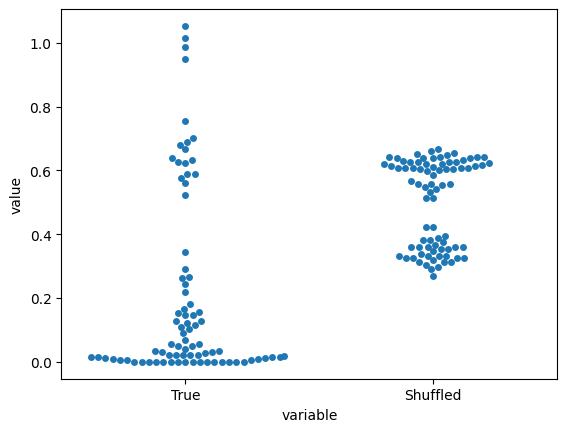

In [56]:
n_parts = 2
random_state = 42
n_parts = 2

rng = np.random.default_rng()  # Random generator for reproducibility
# part_labels = []
all_cluster_repeats = repeated_splits(trial_clusters, vars, n_parts, optimal_k=3, reps=100)
# melted_df = agreement_ratio(all_cluster_repeats)
melted_df = calculate_entropy(all_cluster_repeats)
sns.swarmplot(x='variable', y='value', data=melted_df)

Text(29.222222222222214, 0.5, 'Cluster entropy')

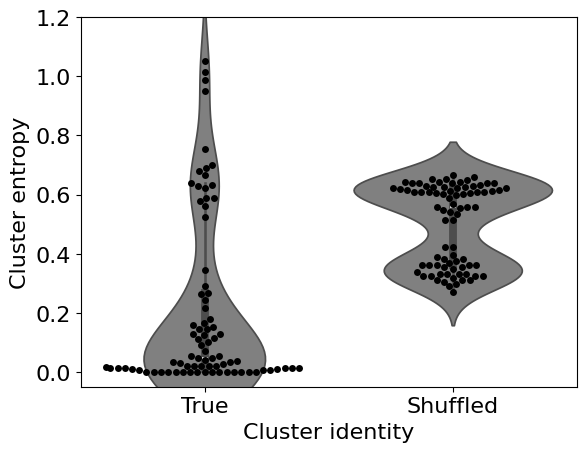

In [59]:
sns.swarmplot(x='variable', y='value', data=melted_df, color='black')
sns.violinplot(x='variable', y='value', data=melted_df, color='grey')
plt.rcParams.update({'font.size': 16})
plt.ylim([-.05, 1.2])
plt.xlabel('Cluster identity')
plt.ylabel('Cluster entropy')

In [14]:
file_to_save = melted_df.copy()
filename = "entropy"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = 'H_clustering_mouse_parts.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

NameError: name 'melted_df' is not defined

## Prepare design matrix

In [10]:
var_names = freq_df.keys()
ori_X = np.array(freq_df[var_names]) #.values
print(np.shape(ori_X))

(430, 7)


## UMAP

In [32]:
repeats = 50
components = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
# components = np.array([1, 2, 4, 6, 8])

### Test for different random seeds

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

Text(0, 0.5, 'Negative log likelihood (SEM)')

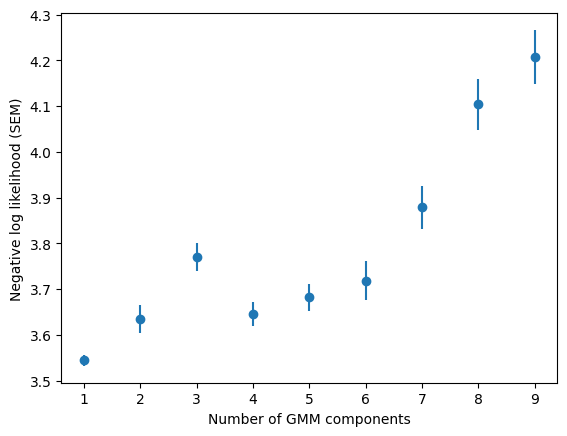

In [33]:
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    
    reducer = umap.UMAP(n_components=2)  # Allow for random seed on each iteration
    # reducer = umap.UMAP(random_state= 42, n_components=2)

    # Standardization using StandardScaler
    scaler = StandardScaler()
    standardized_X = scaler.fit_transform(ori_X)

    # embedding = reducer.fit_transform(standardized_X)
    # embedding.shape

    mouse_embedding = reducer.fit_transform(ori_X)
    mouse_embedding.shape
    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_neg_log_likelihood(mouse_embedding, components)
    
plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Negative log likelihood (SEM)')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")


### Test for different min_dist 

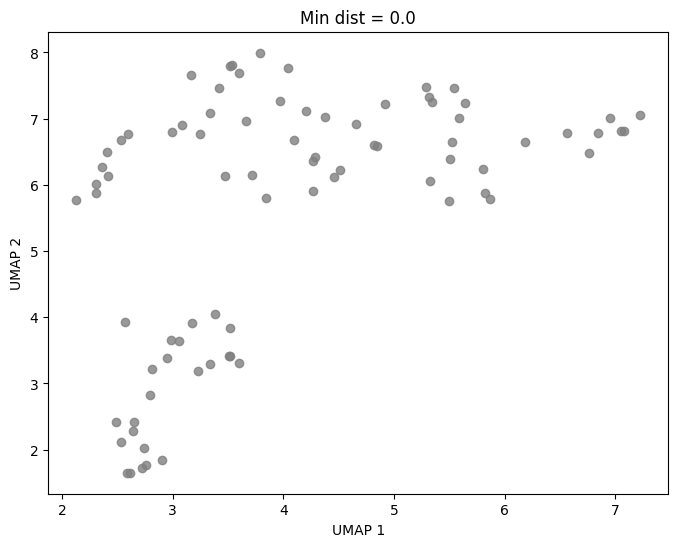

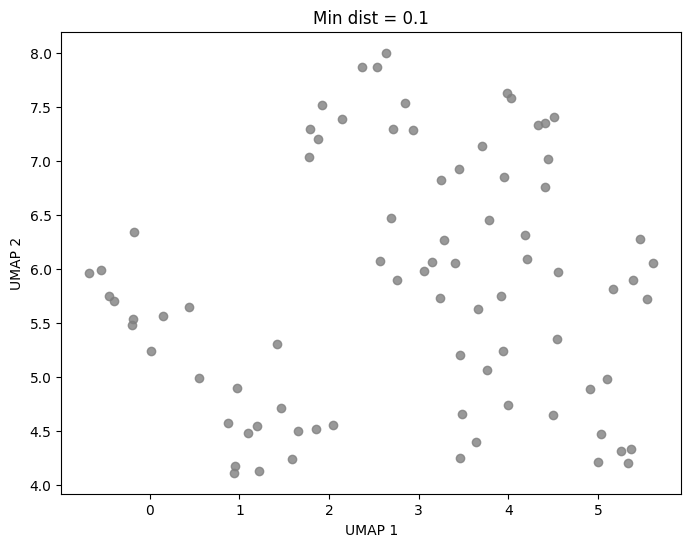

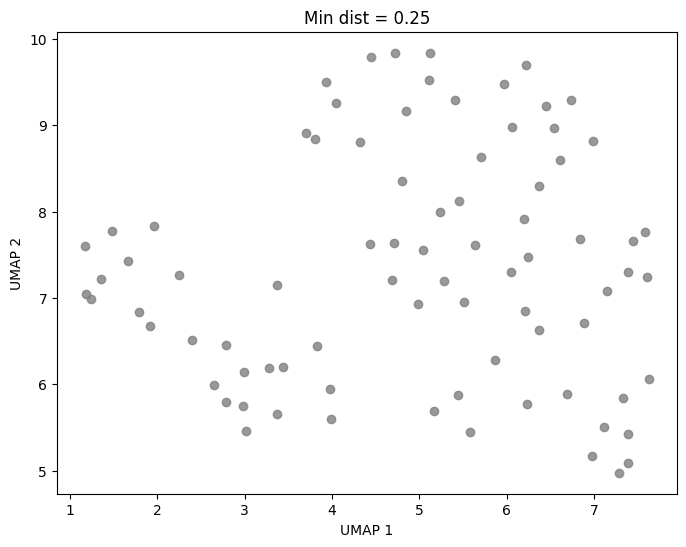

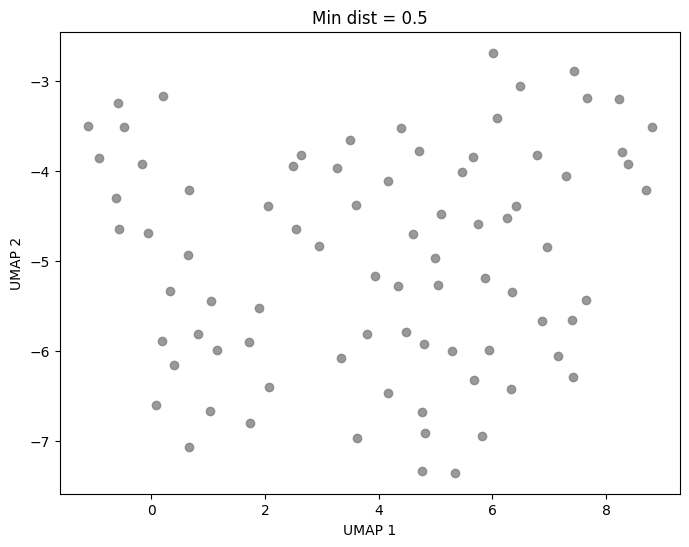

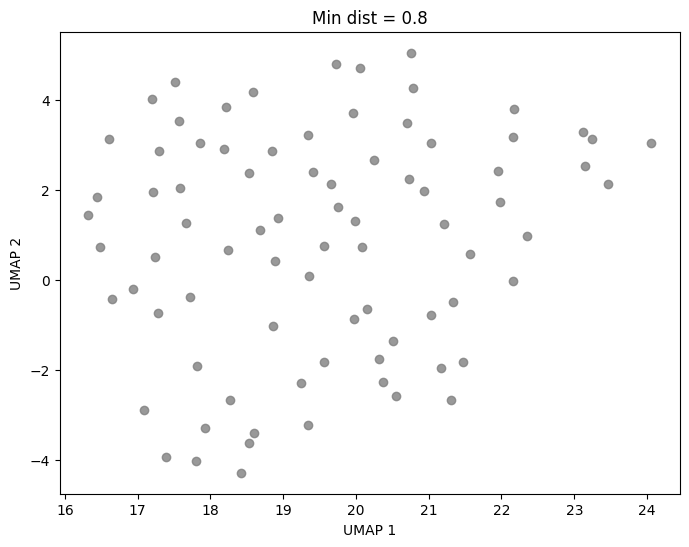

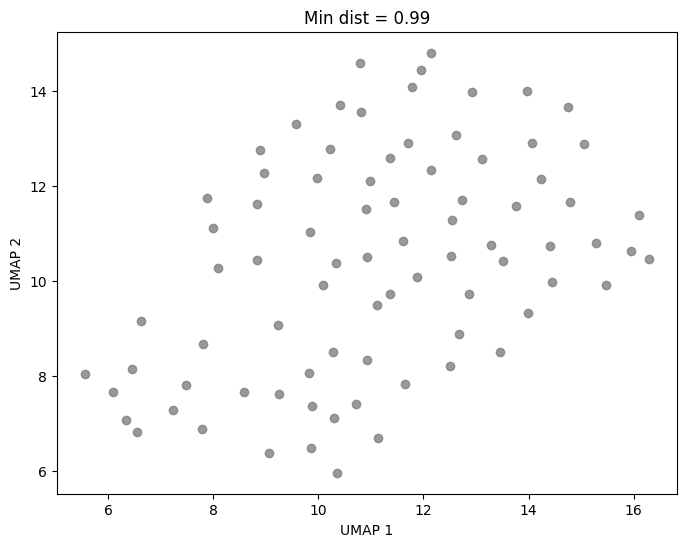

Text(0, 0.5, 'Minimum distance')

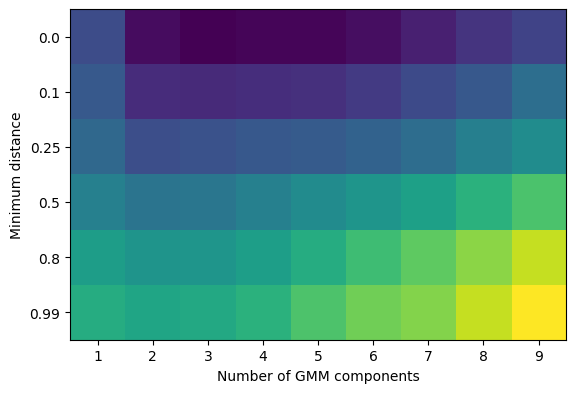

In [105]:
min_dists = np.array([0.0, 0.1, 0.25, 0.5, 0.8, 0.99]) 
LL_min_dist = np.zeros((len(min_dists), len(components))) * np.nan

for d, min_dist in enumerate(min_dists):    
    LLs = np.zeros((repeats, len(components))) * np.nan
    
    for r in range(repeats):  
        
        reducer = umap.UMAP(n_components=2, min_dist=min_dist)  # Allow for random seed on each iteration

        # Standardization using StandardScaler
        scaler = StandardScaler()
        standardized_X = scaler.fit_transform(ori_X)

        mouse_embedding = reducer.fit_transform(ori_X)
        mouse_embedding.shape
        
        # Compute log likelihood of a GMM model with different components
        LLs[r, :] = GMM_neg_log_likelihood(mouse_embedding, components)
    
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        mouse_embedding[:, 0],
        mouse_embedding[:, 1],
        alpha=0.8,
        c='grey'  # Choose a colormap
    )  
    plt.title(str('Min dist = '+str(min_dist)))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    
    # Compute log likelihood of a GMM model with different components
    LL_min_dist[d, :] = np.mean(LLs, axis=0)
    
plt.imshow(LL_min_dist)
plt.yticks([0, 1, 2, 3, 4, 5], min_dists)
plt.xticks(np.arange(0, len(components), 1), components)
# plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(len(min_dists)), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Minimum distance')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")

### Test for different n_neighbours

In [67]:

n_neighbours = np.array([2, 5, 10, 20]) 
LL_neighbours = np.zeros((len(n_neighbours), len(components))) * np.nan

for n, n_neighbour in enumerate(n_neighbours):    
    LLs = np.zeros((repeats, len(components))) * np.nan
    
    for r in range(repeats):  
        
        reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbour)  # Allow for random seed on each iteration

        # Standardization using StandardScaler
        scaler = StandardScaler()
        standardized_X = scaler.fit_transform(ori_X)

        mouse_embedding = reducer.fit_transform(ori_X)
        mouse_embedding.shape
        
        # Compute log likelihood of a GMM model with different components
        LLs[r, :] = GMM_neg_log_likelihood(mouse_embedding, components)
    
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        mouse_embedding[:, 0],
        mouse_embedding[:, 1],
        alpha=0.8,
        c='grey'  # Choose a colormap
    )  
    plt.title(str('N neighbour = '+str(n_neighbour)))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    
    # Compute log likelihood of a GMM model with different components
    LL_neighbours[n, :] = np.mean(LLs, axis=0)
    
plt.imshow(LL_neighbours)
plt.yticks([0, 1, 2, 3], n_neighbours)
plt.xticks(np.arange(0, len(components), 1), components)
# plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(len(min_dists)), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('N neighbors')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [34]:
for d, dist in enumerate(min_dists):
    plt.plot(components, LL_min_dist[d, :], label=dist)
plt.legend()
plt.xlabel('Number of components')
plt.ylabel('Mean Negative log likelihood')
plt.title('Minimum distance')
plt.show()

for n, neighbor in enumerate(n_neighbours):
    plt.plot(components, LL_neighbours[n, :], label=neighbor)
plt.legend()
plt.xlabel('Number of components')
plt.ylabel('Mean Negative log likelihood')
plt.title('N neighbours')
    

NameError: name 'min_dists' is not defined

## Run UMAP with fixed random seed

In [11]:
reducer = umap.UMAP(random_state= 42, n_components=2)

part_embedding = reducer.fit_transform(ori_X)
part_embedding.shape


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(430, 2)

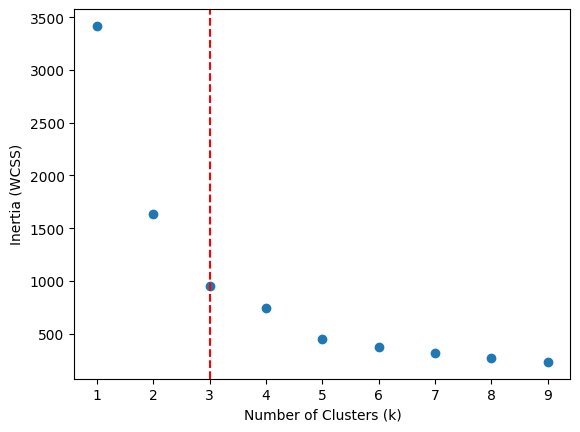

In [12]:
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
# Assuming `X` is your data
inertia_values = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(part_embedding)[0]*0.8)
    X_train = np.vstack([part_embedding[:cutoff, 0], part_embedding[:cutoff, 1]]).T
    kmeans.fit(X_train.copy())
    inertia_values.append(kmeans.inertia_)
    
kneedle = KneeLocator(K, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.show()

## K-means clustering of data

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


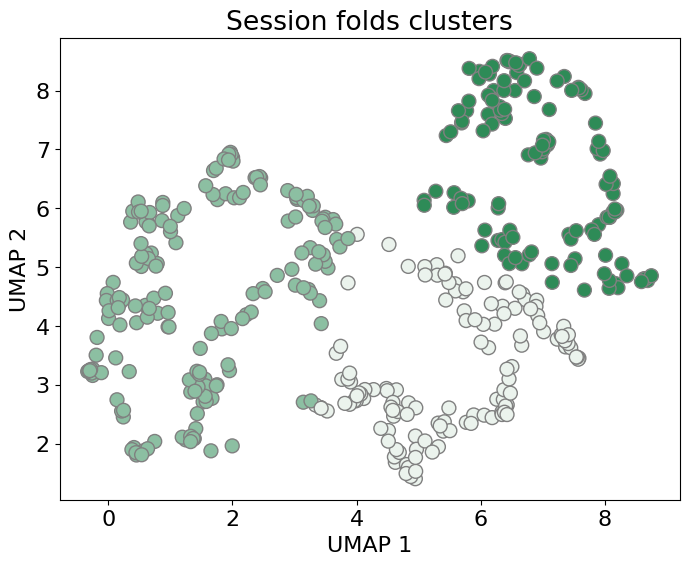

In [22]:
reducer = umap.UMAP(n_components=2)

part_embedding = reducer.fit_transform(ori_X)
part_embedding.shape

# Step 2: Perform KMeans Clustering
data_2d = part_embedding
# kmeans = KMeans(n_clusters=3, random_state=2024)
# kmeans = KMeans(n_clusters=3)
# kmeans.fit(data_2d)
# mouse_y_kmeans = kmeans.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=mouse_y_kmeans,  edgecolors='grey', s=100, alpha=1, cmap=sns.light_palette("seagreen", 3, as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))

plt.title("Session folds clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.savefig(file_path+'umap_mice.svg', format="svg")

plt.show()

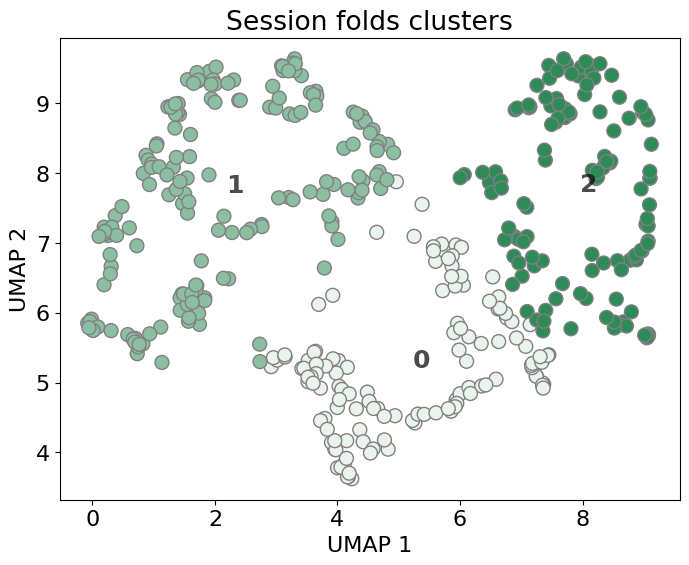

In [20]:
# Step 2: Perform KMeans Clustering
data_2d = part_embedding
# kmeans = KMeans(n_clusters=3, random_state=2024)
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_2d)
temp_y_kmeans = kmeans.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=temp_y_kmeans, s=100, alpha=1, edgecolors='grey', cmap=sns.light_palette("seagreen", 3, as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))


centroids = kmeans.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')

plt.title("Session folds clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.savefig(file_path+'umap_mice.svg', format="svg")

plt.show()

## Save session part clusters data

In [17]:
save_df = freq_df.copy()
save_df = save_df.merge(trial_clusters[['sample', 'mouse_name']].drop_duplicates(), on=['sample'])
save_df['UMAP1'] = part_embedding[:, 0]
save_df['UMAP2'] = part_embedding[:, 1]


save_df['part_cluster'] = mouse_y_kmeans
mouse_clustered_info = count.reset_index().merge(trial_clusters[['sample', 'mouse_name', 'cluster']].drop_duplicates(), on=['sample', 'cluster']).reset_index()
mouse_clustered_info = mouse_clustered_info.merge(save_df.reset_index()[['mouse_name', 'sample', 'part_cluster', 'UMAP1', 'UMAP2']], on=['mouse_name', 'sample'])

In [19]:

# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(save_df.reset_index()['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(save_df.reset_index()['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = save_df.reset_index()['mouse_name'].map(map_mouse_names)

In [23]:
file_to_save = mouse_clustered_info.copy()
filename = "cluster_per_session_part"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.6_clustering_mouse_parts.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

## Test for cluster agreement

In [202]:
from scipy.stats import entropy
new_df = mouse_clustered_info.copy()
shuffle_iter = 100

cluster_entropy = pd.DataFrame(columns=['mouse_name', 'True', 'Shuffled', 'session_len'], index=range(len(new_df['mouse_name'].unique())))
for m, mouse in enumerate(new_df['mouse_name'].unique()):
    cluster_entropy['mouse_name'][m] = mouse
    
    mouse_session_parts = new_df.loc[new_df['mouse_name']==mouse][['mouse_name', 'sample', 'part_cluster']].drop_duplicates()

    # Compute maximum possible entropy (uniform distribution)
    # max_entropy = np.log2(len(prob))  # Since base=2
    
    # Count cluster label occurrences for sample i
    labels, counts = np.unique(np.array(mouse_session_parts['part_cluster']), return_counts=True)
    prob = counts / counts.sum()
    ent = entropy(prob)  # Shannon entropy
    # Normalize
    # normalized_entropy = ent / max_entropy if max_entropy != 0 else 0.0
    
    shuffles = []
    for i in range(shuffle_iter):
        shuffle = np.random.randint(np.min(new_df['part_cluster']), np.max(new_df['part_cluster']), len(mouse_session_parts))
        _, shuffle_counts = np.unique(shuffle, return_counts=True)
        shuff_prob = shuffle_counts / shuffle_counts.sum()
        shuff_ent = entropy(shuff_prob)  # Shannon entropy
        shuffles.append(shuff_ent)
        # Normalize
        # normalized_shuffle_entropy = shuff_ent / max_entropy if max_entropy != 0 else 0.0
        
    cluster_entropy['True'][m] = ent
    cluster_entropy['Shuffled'][m] = np.mean(shuffles)
    cluster_entropy['session_len'][m] = np.floor(len(mouse_session_parts['sample'].unique())/2)
    
    # print(labels, counts, ent)
    
    # sns.scatterplot(x='UMAP1', y='UMAP2', hue='session_cluster', data=new_df.loc[new_df['mouse_name']==mouse])
    # plt.xlim([-.5, 5])
    # plt.ylim([1.5, 10.5])
    # plt.show()

melted_df = pd.melt(cluster_entropy, id_vars=['mouse_name', 'session_len'], value_vars=['True', 'Shuffled'])

/tmp/ipykernel_16019/1447169909.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cluster_entropy['mouse_name'][m] = mouse
/tmp/ipykernel_16019/1447169909.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
Y

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(29.222222222222214, 0.5, 'Mouse cluster entropy')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 35.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


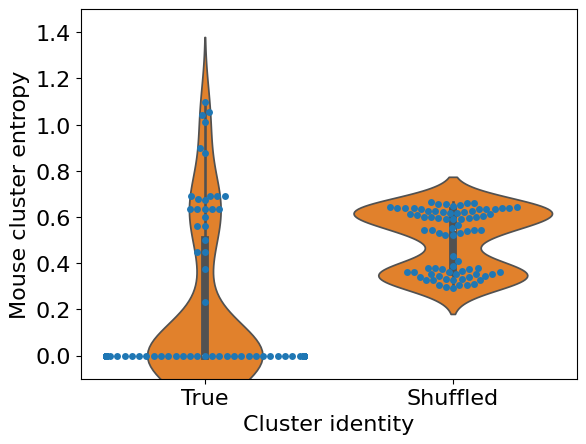

In [203]:
sns.swarmplot(x='variable', y='value', data=melted_df)
sns.violinplot(x='variable', y='value', data=melted_df)
plt.xlabel('Cluster identity')
plt.ylim([-.1, 1.5])
plt.ylabel('Mouse cluster entropy')

Text(29.222222222222214, 0.5, 'Mouse cluster entropy')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 32.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


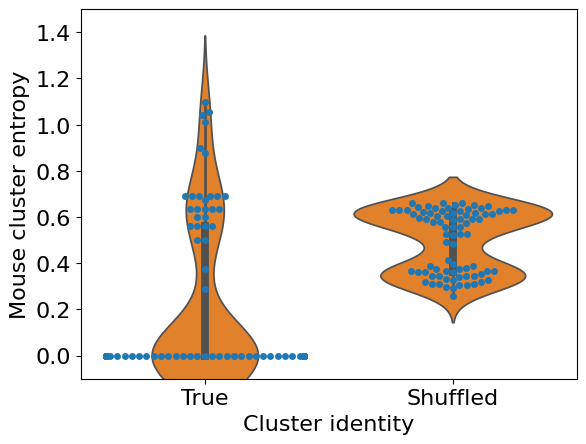

In [65]:
sns.swarmplot(x='variable', y='value', data=melted_df)
sns.violinplot(x='variable', y='value', data=melted_df)
plt.xlabel('Cluster identity')
plt.ylim([-.1, 1.5])
plt.ylabel('Mouse cluster entropy')

In [88]:
len(melted_df.loc[(melted_df['session_len']>1) & (melted_df['variable']=='True') & (melted_df['value']<.5)])

27

In [89]:
file_to_save = melted_df.copy()
filename = "entropy"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = 'H_clustering_mice.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

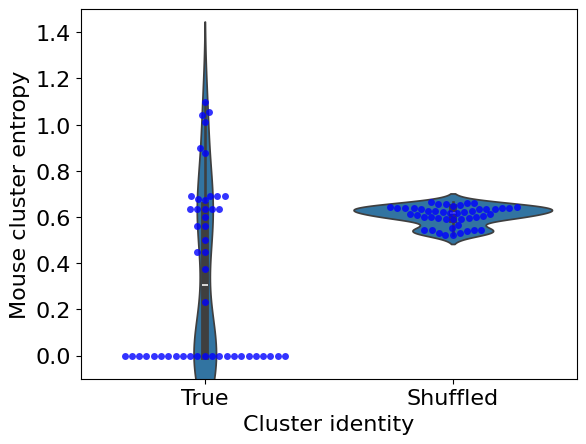

Text(29.222222222222214, 0.5, 'Mouse cluster entropy')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


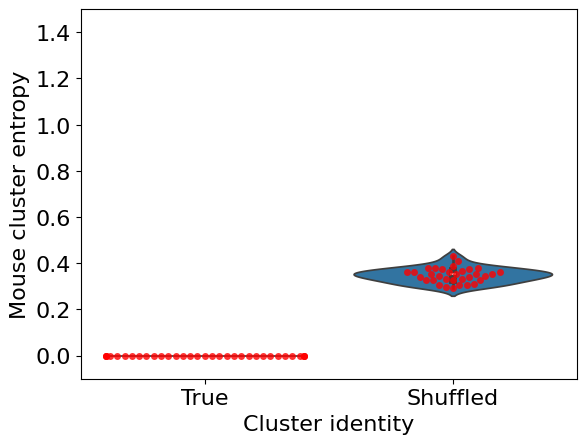

In [204]:
sns.swarmplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']>1], color='blue', alpha=.8)
sns.violinplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']>1])
plt.xlabel('Cluster identity')
plt.ylim([-.1, 1.5])
plt.ylabel('Mouse cluster entropy')
plt.show()

sns.swarmplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']<=1], color='red', alpha=.8)
sns.violinplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']<=1])
plt.xlabel('Cluster identity')
plt.ylim([-.1, 1.5])
plt.ylabel('Mouse cluster entropy')